In [1]:
#combine Test data and Weather data
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress
import scipy.stats as stats
import seaborn as sns

In [2]:
#load CSVs
wdf =[]
wdf = pd.read_csv("Complied_Weather.csv")
idf = pd.read_csv("Data/Total Positives for Desired States.csv")

In [3]:
#replace wdf states with full name
wdf['State'].replace({'AZ':'Arizona','CA':'California','CO':'Colorado','GA':'Georgia','IL':'Illinois','NY':'New York',
                      'PA':'Pennsylvania','TX':'Texas','WA':'Washington'},inplace=True)

wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_day_of_the_week  6589 non-null   object 
 1   average_temperature   6589 non-null   float64
 2   week                  6589 non-null   int64  
 3   year                  6589 non-null   int64  
 4   State                 6589 non-null   object 
 5   City                  6589 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 309.0+ KB


In [4]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   State                     2349 non-null   object
 1   year                      2349 non-null   int64 
 2   week                      2349 non-null   int64 
 3   Total Positive Flu Tests  2349 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 73.5+ KB


In [5]:
#Merge weather df and ILI df and save as CSV
widf = pd.merge(idf,wdf,on=['State','week','year'])

In [6]:
#Convert last_day_of_the_week to datetime and add column
widf['ldw_num'] = widf.loc[:,'last_day_of_the_week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
widf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 0 to 2859
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   State                     2860 non-null   object        
 1   year                      2860 non-null   int64         
 2   week                      2860 non-null   int64         
 3   Total Positive Flu Tests  2860 non-null   int64         
 4   last_day_of_the_week      2860 non-null   object        
 5   average_temperature       2860 non-null   float64       
 6   City                      2860 non-null   object        
 7   ldw_num                   2860 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 201.1+ KB


In [7]:
#Form new dataframe removing 2019-2020 flu season as COVID skewing data
# DF_no2020 =widf[widf['ldw_num']<('2019-10-01')]
# DF_no2020.info()

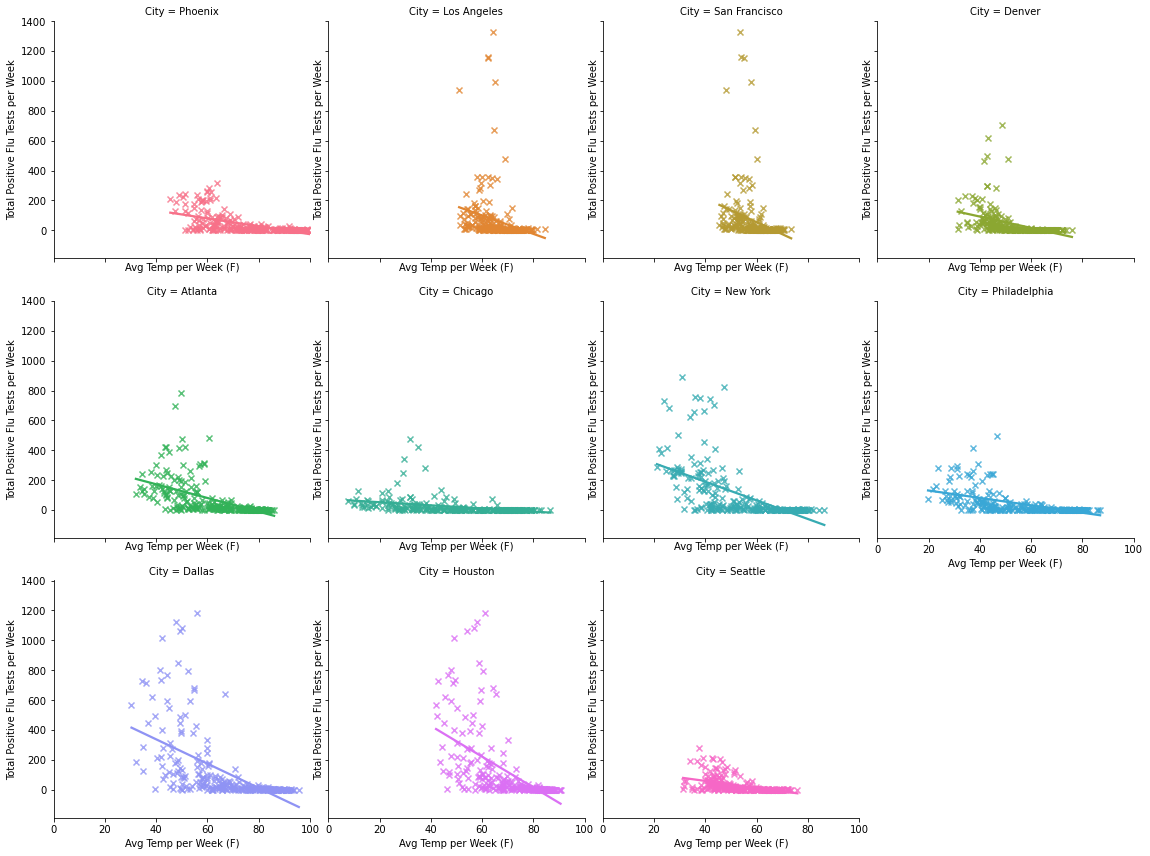

In [8]:
#Show scatter plot of each city with best fit line
grid_plot = sns.lmplot(x='average_temperature', y='Total Positive Flu Tests', col="City", hue="City",
                       data=widf, ci=None, col_wrap = 4, height = 4, markers='x')
grid_plot.set(xlim=(0,100), xlabel='Avg Temp per Week (F)',ylabel='Total Positive Flu Tests per Week')
grid_plot.savefig(f'Plots/Scatter_Plots/Tested_Cases/Flu Test Totals vs. Avg. Temperature for All States.png')

In [9]:
#Form unique list of cities
Cities = widf.City.unique()
Cities_df = pd.DataFrame(Cities, columns=['Cities'])
Cities_df

,Cities
0,Phoenix
1,Los Angeles
2,San Francisco
3,Denver
4,Atlanta
5,Chicago
6,New York
7,Philadelphia
8,Dallas
9,Houston


In [10]:
#Run for loop to get dataframe for each city; Return city index[5] - Chicago
dataframe = []
for city in range(len(Cities)):
    dataframe.append(widf[widf['City']==Cities[city]])
dataframe[5].head()

,State,year,week,Total Positive Flu Tests,last_day_of_the_week,average_temperature,City,ldw_num
5,Illinois,2010,40,0,2010-10-10,61.642857,Chicago,2010-10-10
16,Illinois,2010,41,4,2010-10-17,58.357143,Chicago,2010-10-17
27,Illinois,2010,42,1,2010-10-24,53.785714,Chicago,2010-10-24
38,Illinois,2010,43,0,2010-10-31,51.357143,Chicago,2010-10-31
49,Illinois,2010,44,2,2010-11-07,41.214286,Chicago,2010-11-07


In [11]:
#Pass each cities dataframe through loop to return regression results
#Form empty lists for x and y values for scatter plot/line plot
temp_values = []
test_values = []
ldw_num_values = []

#Form empty lists to store regression values
slope_results = []
intercept_results = []
rvalue_results = []
regress_values = []
line_eq = []
r_squared = []

#Run for loop to get all regression values for each city
for variable in range(len(dataframe)):
    #Append x and y lists with temperature and ILI Total from individual city's dataframe
    temp_values.append(dataframe[variable]['average_temperature'])
    test_values.append(dataframe[variable]['Total Positive Flu Tests'])
    ldw_num_values.append(dataframe[variable]['ldw_num'])
    
    #Perform the regression analysis on above variables and append each list for individual city
    [slope, intercept, rvalue, pvalue, stderr] = linregress(temp_values[variable], test_values[variable])
    slope_results.append(slope)
    intercept_results.append(intercept)
    rvalue_results.append(rvalue)
    regress_values.append(temp_values[variable] * slope_results[variable] + intercept_results[variable])
    line_eq.append("y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)))
    r_squared.append("R^2 = " + str(round(rvalue**2,3)))

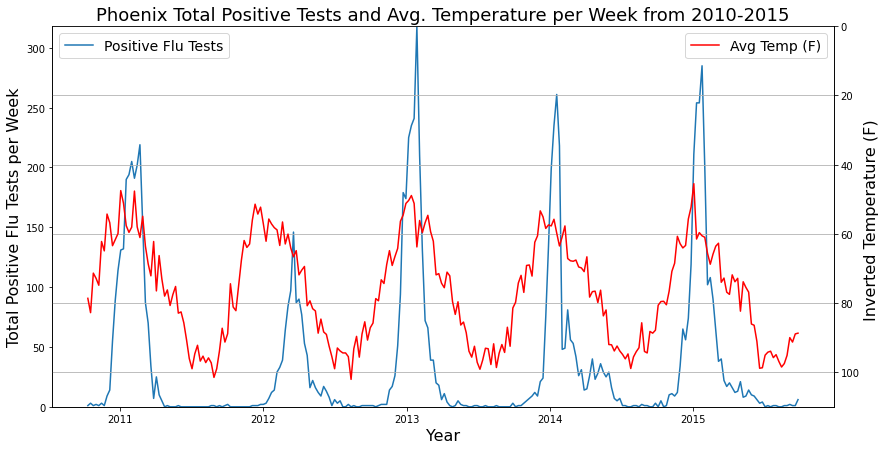

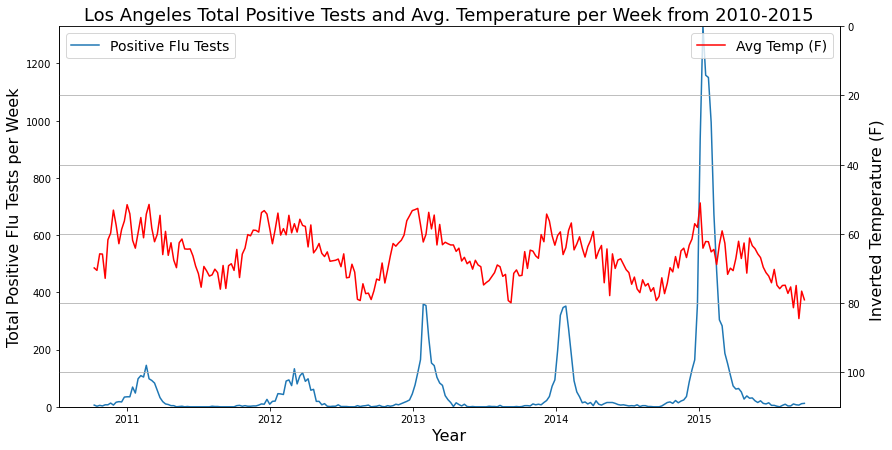

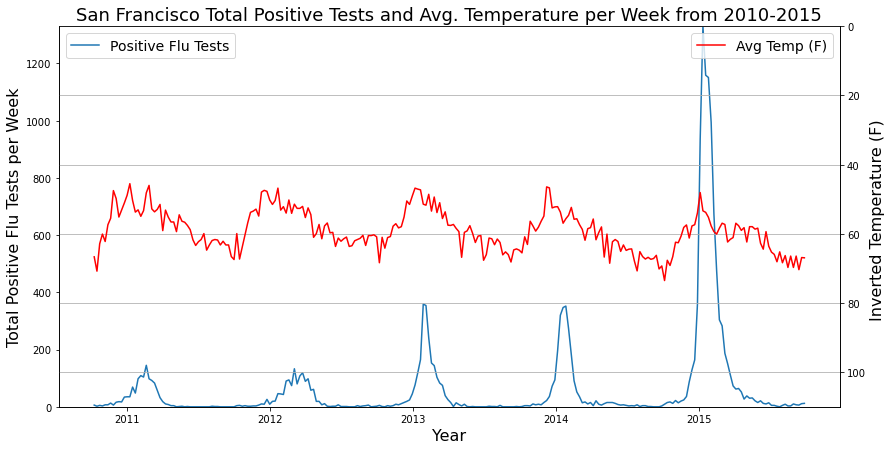

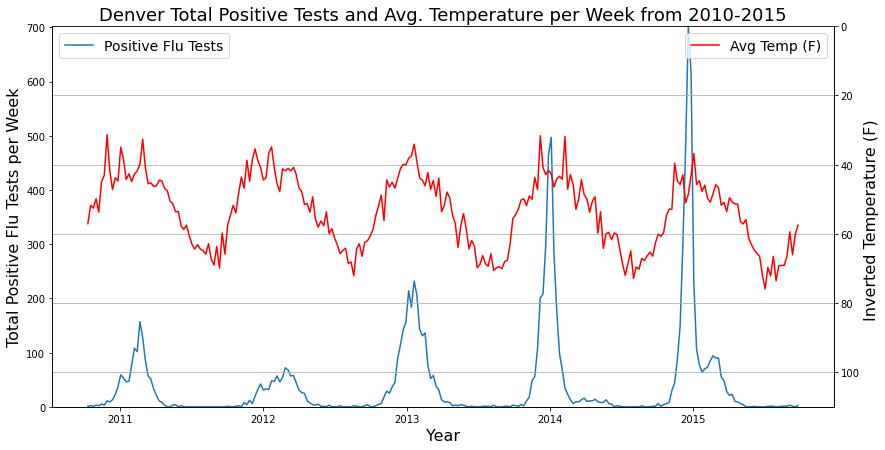

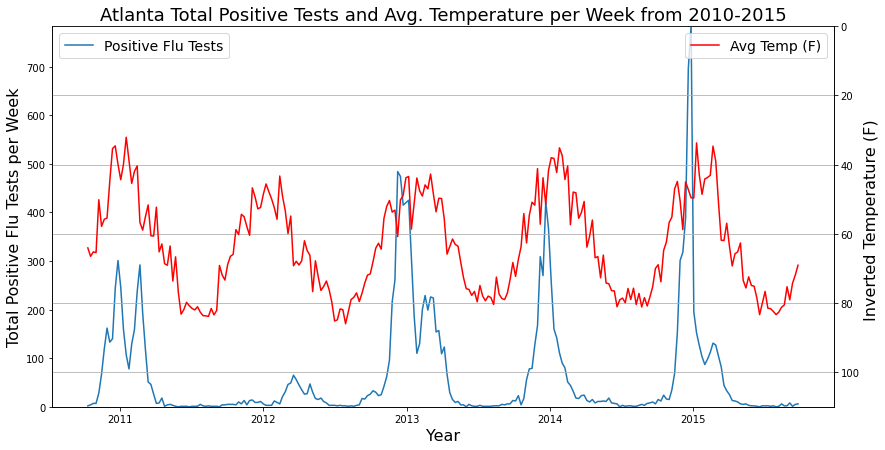

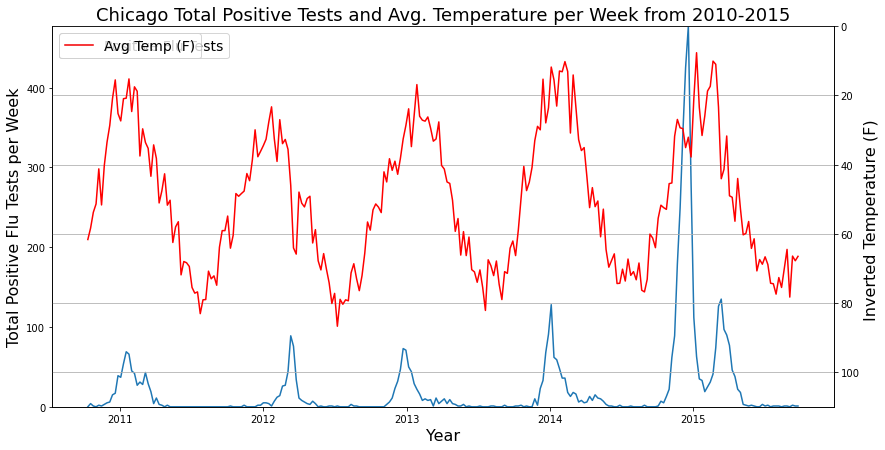

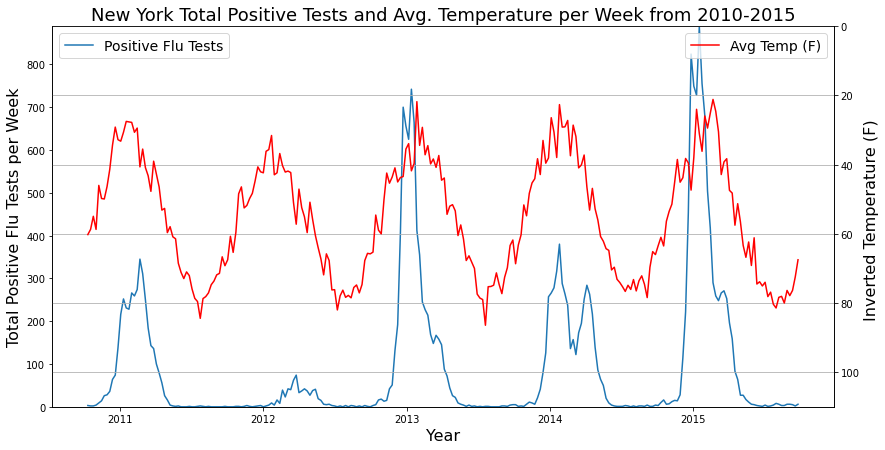

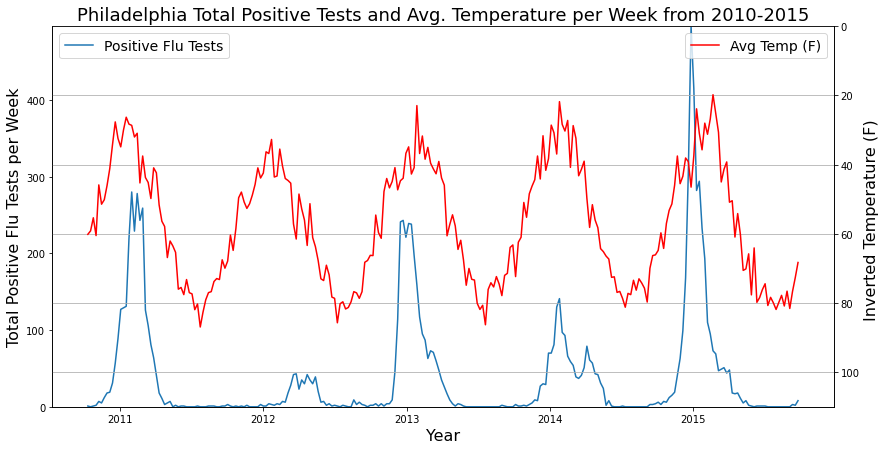

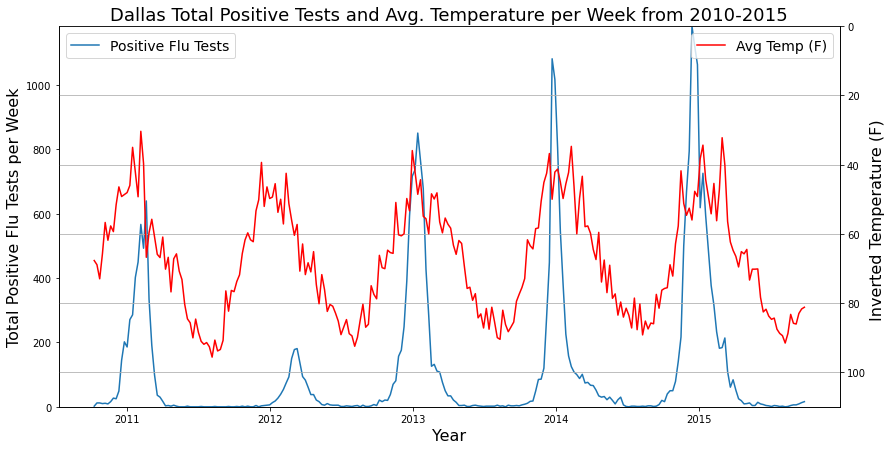

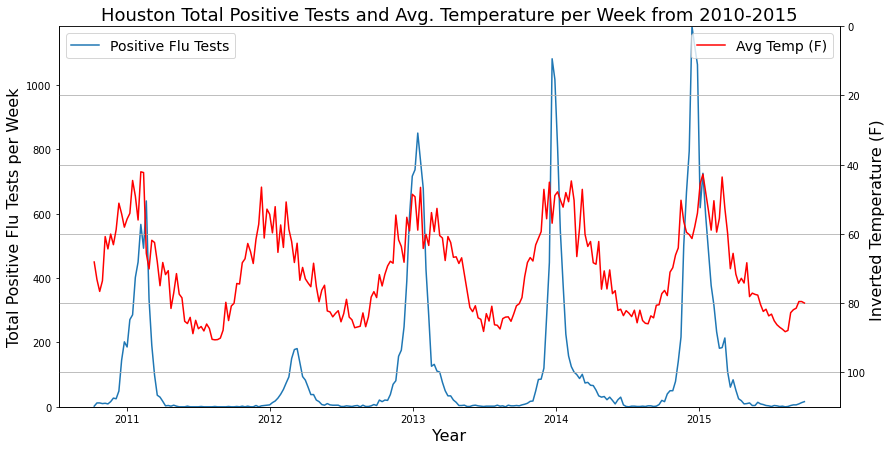

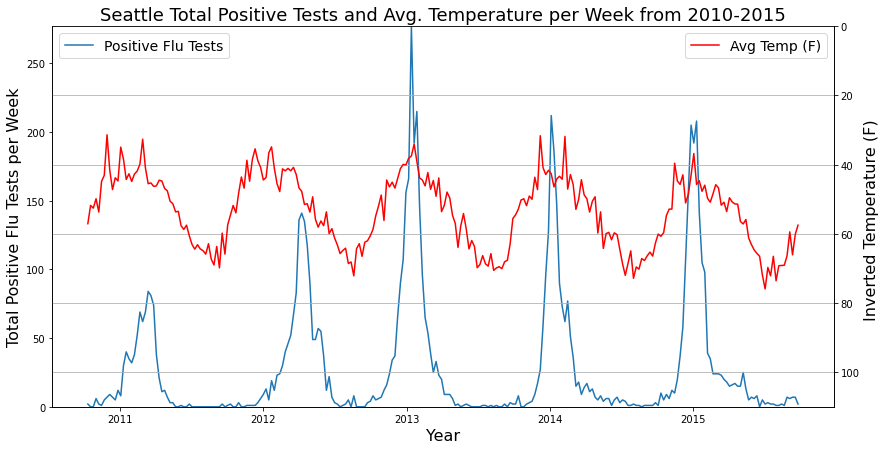

In [12]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(Cities)):
    #Form first plot using ILI cases by week
    fig, ax1 = plt.subplots()
    ax1.plot(ldw_num_values[city],test_values[city], label='Positive Flu Tests')
    plt.ylabel('Total Positive Flu Tests per Week', fontsize = 16)
    plt.xlabel('Year', fontsize = 16)
    ax1.legend(loc='upper left',fontsize = 14)
    plt.ylim((0,test_values[city].max()))

    #Form second plot using same x-axis but secondary y-axis for average temperature
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.plot(ldw_num_values[city],temp_values[city], label='Avg Temp (F)',color ='red')
    plt.ylim((0,110))
    plt.gca().invert_yaxis() #invert y-axis so trend is similar
    plt.ylabel('Inverted Temperature (F) ', fontsize = 16)
    ax2.legend(fontsize = 14)

    #Show dual plot w/ grid and save plot to picture file
    plt.grid(True)
    plt.title(f'{Cities[city]} Total Positive Tests and Avg. Temperature per Week from 2010-2015', fontsize = 18)
    fig.set_size_inches(14, 7, forward=True)
    filepath = (f'Plots/Line_Plots/Tested_Cases/{Cities[city]} Total Positive Tests and Avg. Temperature per Week from 2010-2015.png')
    plt.savefig(filepath)
plt.show()

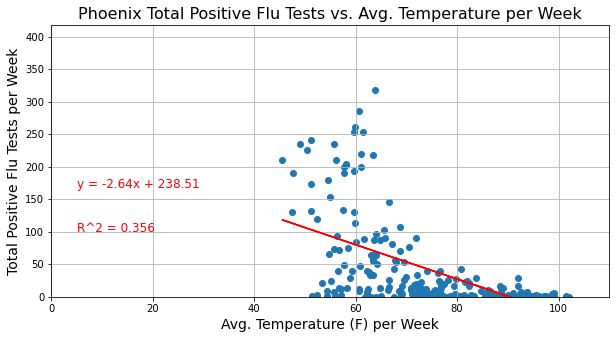

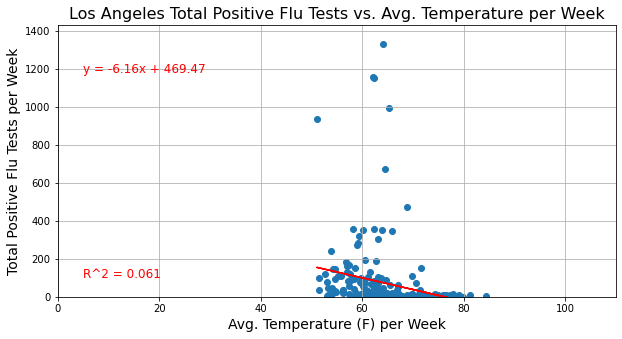

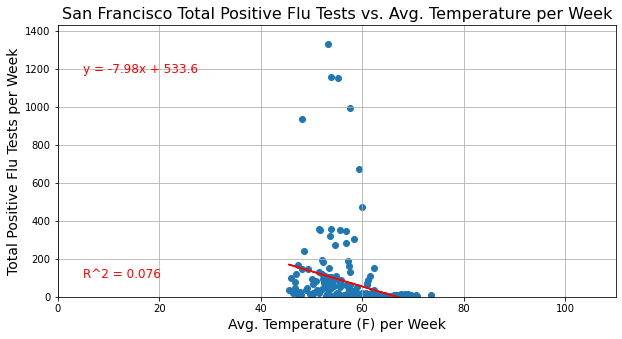

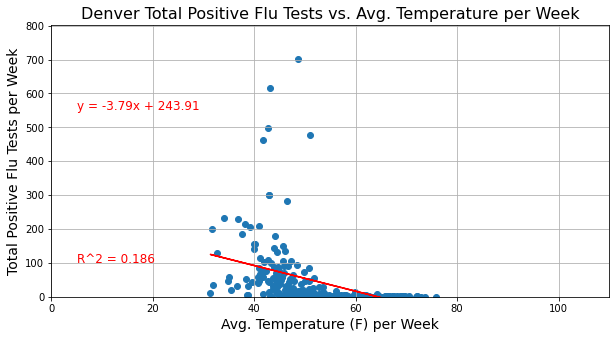

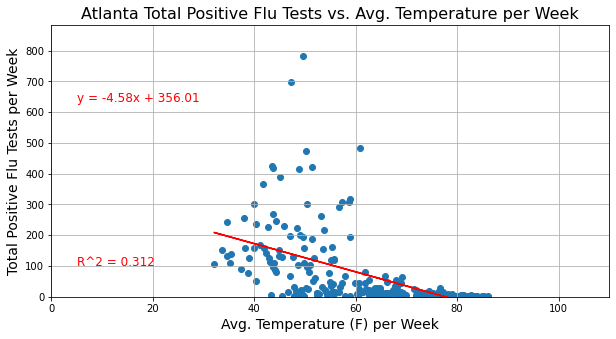

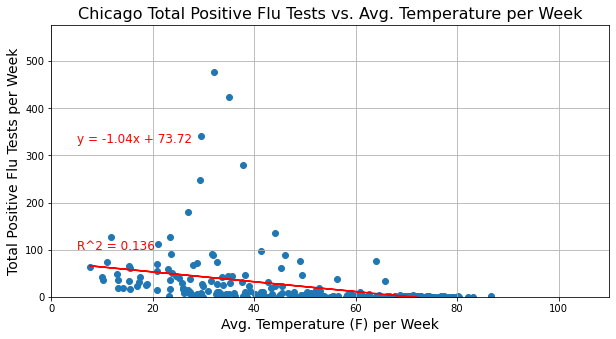

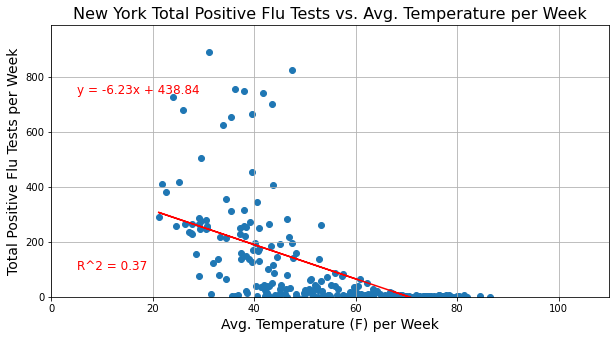

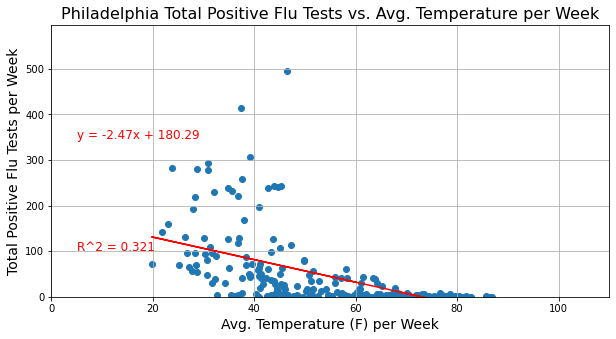

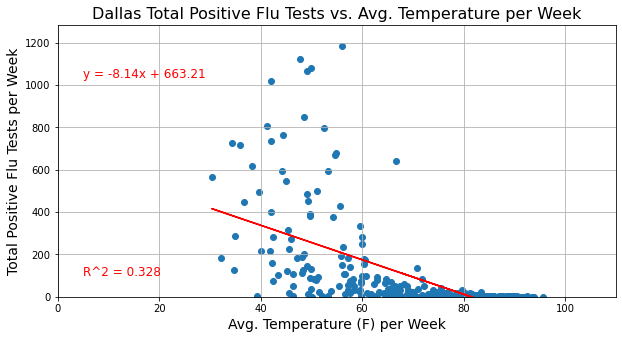

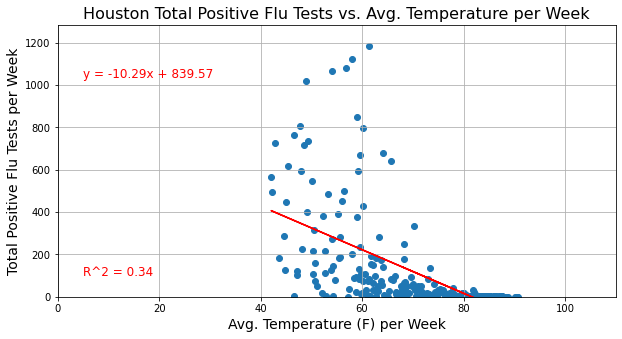

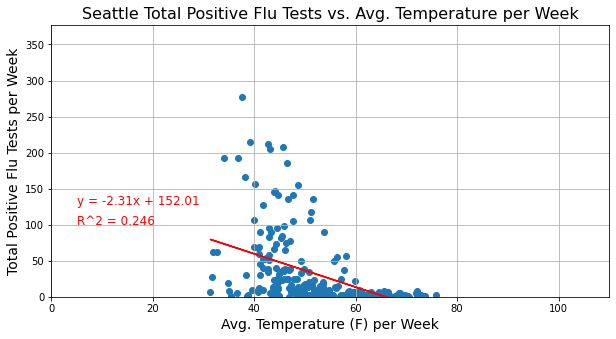

In [13]:
#Return scatterplot w/ best-fit line for each State and save to file
for city in range(len(Cities)):
    plt.figure(figsize=(10,5))
    plt.scatter(temp_values[city],test_values[city])
    plt.grid(True)
    plt.plot(temp_values[city],regress_values[city],"r-")
    plt.annotate(line_eq[city],(5,test_values[city].max()-150),fontsize=12,color='r')
    plt.annotate(r_squared[city],(5,test_values[city].min()+100),fontsize=12, color='r')
    plt.ylabel('Total Positive Flu Tests per Week', fontsize = 14)
    plt.ylim((0,test_values[city].max()+100))
    plt.xlabel('Avg. Temperature (F) per Week', fontsize = 14)
    plt.xlim((0,110))
    plt.title(f'{Cities[city]} Total Positive Flu Tests vs. Avg. Temperature per Week', fontsize=16)
    filepath = (f'Plots/Scatter_Plots/Tested_Cases/{Cities[city]} ILI Total Cases vs. Avg. Temperature.png')
    plt.savefig(filepath)
plt.show()

In [18]:
#Gather scatter plot data into dataframe and sort by R-squared values
Summary_df = pd.DataFrame({'City': Cities, 'Line equation': line_eq, 'R-squared': r_squared})
Summary_df.sort_values(by='R-squared', ascending=False)

,City,Line equation,R-squared
6,New York,y = -6.23x + 438.84,R^2 = 0.37
0,Phoenix,y = -2.64x + 238.51,R^2 = 0.356
9,Houston,y = -10.29x + 839.57,R^2 = 0.34
8,Dallas,y = -8.14x + 663.21,R^2 = 0.328
7,Philadelphia,y = -2.47x + 180.29,R^2 = 0.321
4,Atlanta,y = -4.58x + 356.01,R^2 = 0.312
10,Seattle,y = -2.31x + 152.01,R^2 = 0.246
3,Denver,y = -3.79x + 243.91,R^2 = 0.186
5,Chicago,y = -1.04x + 73.72,R^2 = 0.136
2,San Francisco,y = -7.98x + 533.6,R^2 = 0.076


In [19]:
#Export dataframe to CSV
Summary_df.to_csv('Plots/Scatter_Plots/Tested_Cases/Summary Table for Flu Tests vs. Temp. Scatter Plots.csv', index=False)